In [2]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kienanana/Documents/SCHOOL/Y3S1/BT4222/PROJECT/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kienanana/Documents/SCHOOL/Y3S1/BT4222/PROJECT/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kienanana/Documents/SCHOOL/Y3S1/BT4222/PROJECT/.venv/lib/py

In [3]:
def read_json_in_chunks(file_path, chunk_size=10000):
    """Read large JSON file in chunks"""
    chunks = []
    
    with open(file_path, 'r') as file:
        chunk = []
        for i, line in enumerate(file):
            chunk.append(line)
            
            if (i + 1) % chunk_size == 0:
                chunk_df = pd.read_json('\n'.join(chunk), lines=True)
                chunks.append(chunk_df)
                chunk = []  
        
        # process remaining lines
        if chunk:
            chunk_df = pd.read_json('\n'.join(chunk), lines=True)
            chunks.append(chunk_df)
    
    return pd.concat(chunks, ignore_index=True)

In [ ]:
reviews_file_path = "../data/processed/sf-sampled-reviews.json"
reviews_df = read_json_in_chunks(reviews_file_path);
restaurants_file_path = "../data/processed/sf-restaurants.json"
restaurants_df = read_json_in_chunks(restaurants_file_path);

In [5]:
print(reviews_df.shape)
print(restaurants_df.shape)

(411496, 6)
(3721, 15)


In [6]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411496 entries, 0 to 411495
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  411496 non-null  float64
 1   name     411496 non-null  object 
 2   time     411496 non-null  int64  
 3   rating   411496 non-null  int64  
 4   text     220550 non-null  object 
 5   gmap_id  411496 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 18.8+ MB


In [9]:
# --- Load aspect features (Parquet) ---
from pathlib import Path

FEAT_DIR = Path("../data/processed/features/aspects")
user_aspects = pd.read_parquet(FEAT_DIR / "user_aspect_prefs.parquet")
item_aspects = pd.read_parquet(FEAT_DIR / "item_aspect_prefs.parquet")

user_aspects["user_id"] = user_aspects["user_id"].astype(str)
item_aspects["gmap_id"] = item_aspects["gmap_id"].astype(str)
reviews_df["user_id"] = reviews_df["user_id"].astype(str)
reviews_df["gmap_id"] = reviews_df["gmap_id"].astype(str)

# select aspect columns
ASPECTS = ["food","service","price","ambience","cleanliness","portion","wait_time","location"]
U_COLS = ["user_id","n_reviews"] + [f"{a}_pref" for a in ASPECTS]
I_COLS = ["gmap_id","n_reviews"] + [f"{a}_pref" for a in ASPECTS]

user_aspects = user_aspects[U_COLS].rename(columns={"n_reviews":"u_n_reviews", **{f"{a}_pref":f"u_{a}" for a in ASPECTS}})
item_aspects = item_aspects[I_COLS].rename(columns={"n_reviews":"i_n_reviews", **{f"{a}_pref":f"i_{a}" for a in ASPECTS}})

# join onto interactions
reviews_df = reviews_df.merge(user_aspects, on="user_id", how="left")
reviews_df = reviews_df.merge(item_aspects, on="gmap_id", how="left")

# fill missing (cold-start) with zeros
for a in ASPECTS:
    reviews_df[f"u_{a}"] = reviews_df[f"u_{a}"].fillna(0.0)
    reviews_df[f"i_{a}"] = reviews_df[f"i_{a}"].fillna(0.0)
reviews_df["u_n_reviews"] = reviews_df["u_n_reviews"].fillna(0).astype(np.int32)
reviews_df["i_n_reviews"] = reviews_df["i_n_reviews"].fillna(0).astype(np.int32)

In [10]:
user_encoder = LabelEncoder()
restaurant_encoder = LabelEncoder()

reviews_df["user_encoded"] = user_encoder.fit_transform(reviews_df["user_id"])
reviews_df["restaurant_encoded"] = restaurant_encoder.fit_transform(reviews_df["gmap_id"])

reviews_df["label"] = reviews_df["rating"]
reviews_df["label_binary"] = (reviews_df["rating"] >= 4).astype(int)

## Dataset Sparsity () counts-only
U = reviews_df["user_encoded"].nunique()
I = reviews_df["restaurant_encoded"].nunique()
N = len(reviews_df)
sparsity = N / (U * I)

reviews_df['timestamp'] = pd.to_datetime(reviews_df['time'])
reviews_df = reviews_df.sort_values('timestamp')

split_idx = int(len(reviews_df) * 0.8)
train_df = reviews_df.iloc[:split_idx]
test_df = reviews_df.iloc[split_idx:]

print(f"Users (U): {U}")
print(f"Restaurants (I): {I}")
print(f"Interactions (N): {N}")
print(f"Data Sparsity: {sparsity*100:.2f}%")

Users (U): 131972
Restaurants (I): 3721
Interactions (N): 411496
Data Sparsity: 0.08%


In [15]:
layer_sizes=[128, 256, 512, 256, 64]
dropout_sizes = [0.2,0.3,0.4,0.3,0.2]

class MLPBlock(nn.Module):
    """A reusable fully-connected block with optional BatchNorm, ReLU, and Dropout."""
    def __init__(self, in_dim, out_dim, dropout=0.0, use_bn=True):
        super().__init__()
        layers = [nn.Linear(in_dim, out_dim)]
        if use_bn:
            layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.ReLU())
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class NCFModel(nn.Module):
    def __init__(self, num_users, num_restaurants, embedding_dim=64, extra_dim=0):
        super(NCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_restaurants, embedding_dim)

        mlp_layers = []
        input_dim = embedding_dim * 2 + extra_dim
        for i in range(len(layer_sizes)):
            hidden_dim = layer_sizes[i]
            dropout = dropout_sizes[i]
            mlp_layers.append(MLPBlock(input_dim, hidden_dim, dropout=dropout))
            input_dim = hidden_dim
        mlp_layers.append(nn.Linear(input_dim, 1))  # output layer
        self.mlp=nn.Sequential(*mlp_layers)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)


    def forward(self, user, item, side_feats=None):
        u = self.user_embedding(user)
        i = self.item_embedding(item)
        x = torch.cat([u, i], dim=1)
        if side_feats is not None:
            x = torch.cat([x, side_feats], dim=1)
        logits = self.mlp(x)
        return logits


In [14]:
USER_FEATS = [f"u_{a}" for a in ASPECTS] + ["u_n_reviews"]
ITEM_FEATS = [f"i_{a}" for a in ASPECTS] + ["i_n_reviews"]
SIDE_FEATS = USER_FEATS + ITEM_FEATS  # 8+1 + 8+1 = 18 dims

class ReviewsDataset(Dataset):
    def __init__(self, dataframe, use_side_feats=True):
        self.use_side_feats = use_side_feats
        self.users = torch.tensor(dataframe["user_encoded"].values, dtype=torch.long)
        self.items = torch.tensor(dataframe["restaurant_encoded"].values, dtype=torch.long)
        self.labels = torch.tensor(dataframe["label"].values, dtype=torch.float32)
        if use_side_feats:
            X = dataframe[SIDE_FEATS].astype(np.float32).values
            self.x = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.use_side_feats:
            return self.users[idx], self.items[idx], self.x[idx], self.labels[idx]
        else:
            return self.users[idx], self.items[idx], self.labels[idx]

train_dataset = ReviewsDataset(train_df)
test_dataset = ReviewsDataset(test_df)

USE_SIDE_FEATS = True
train_dataset = ReviewsDataset(train_df, use_side_feats=USE_SIDE_FEATS)
test_dataset  = ReviewsDataset(test_df,  use_side_feats=USE_SIDE_FEATS)

def collate_fn(batch):
    if USE_SIDE_FEATS:
        u,i,x,y = zip(*batch)
        return (torch.stack(u), torch.stack(i), torch.stack(x), torch.stack(y))
    else:
        u,i,y = zip(*batch)
        return (torch.stack(u), torch.stack(i), torch.stack(y))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=1028, shuffle=False, collate_fn=collate_fn)


In [13]:
num_users = reviews_df["user_encoded"].nunique()
num_restaurants = reviews_df["restaurant_encoded"].nunique()
print(num_users, num_restaurants)

131972 3721


In [20]:
## original training cell
model = NCFModel(num_users, num_restaurants)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

train_losses, val_losses = [], []

for epoch in range(20):

    model.train()
    training_loss = 0
    total_samples = 0
    for u, i, r in train_loader:
        u, i, r = u.to(device), i.to(device), r.to(device)

        optimizer.zero_grad()
        logits = model(u, i).squeeze(-1)

        loss = criterion(logits, r)
        training_loss += loss.item() * r.size(0)
        total_samples += r.size(0)

        loss.backward()
        optimizer.step()

    average_training_loss = training_loss / total_samples
    train_losses.append(average_training_loss)
    training_rmse = np.sqrt(average_training_loss)

    if average_training_loss < 1.0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 2e-5  

    model.eval()
    num_correct = 0
    val_loss = 0
    all_preds, all_labels =  [], []

    with torch.no_grad():
        for u, i, r in test_loader:
            u, i, r = u.to(device), i.to(device), r.to(device)
            logits = model(u,i).squeeze(-1)

            all_preds.extend(logits.cpu().numpy())
            all_labels.extend(r.cpu().numpy())

            predictions = (logits >= 4).int()
            actual = (r>= 4).int()
            new_correct = (predictions == actual).sum().item()
            num_correct += new_correct

            loss = criterion(logits, r)
            val_loss += loss.item()*r.size(0)

    average_val_loss = val_loss/len(all_preds)
    val_rmse = np.sqrt(average_val_loss)
    val_losses.append(average_val_loss)
    accuracy = num_correct / len(all_labels)


    print("====================================================================================")
    print(f"Epoch {epoch+1}:")
    print(f"Training Loss: {average_training_loss:.4f}, Validation Loss: {average_val_loss:.4f}")
    print(f"Training RMSE: {training_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    print(f"Validation Accuracy: {100*accuracy:.4f}%")


# Plotting of training and validation loss curves
plt.plot(range(1, 21), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, 21), val_losses, label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True, alpha=0.3)
plt.show()

NCFModel(
  (user_embedding): Embedding(131972, 64)
  (item_embedding): Embedding(3721, 64)
  (mlp): Sequential(
    (0): MLPBlock(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (1): MLPBlock(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): MLPBlock(
      (block): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.4, inplace=False)
      )
    )
    (3): MLPBlock(
      (block): Sequ

ValueError: too many values to unpack (expected 3)

Epoch 1:
Training Loss: 9.8849, Validation Loss: 4.8018
Training RMSE: 3.1440, Validation RMSE: 2.1913
Validation Accuracy: 14.3840%
(early-stop) best_val=4.8018 | patience=0/3
Epoch 2:
Training Loss: 2.4780, Validation Loss: 1.4429
Training RMSE: 1.5742, Validation RMSE: 1.2012
Validation Accuracy: 14.5468%
(early-stop) best_val=1.4429 | patience=0/3
Epoch 3:
Training Loss: 1.2458, Validation Loss: 0.9807
Training RMSE: 1.1162, Validation RMSE: 0.9903
Validation Accuracy: 81.3135%
(early-stop) best_val=0.9807 | patience=0/3
Epoch 4:
Training Loss: 1.0949, Validation Loss: 0.9823
Training RMSE: 1.0464, Validation RMSE: 0.9911
Validation Accuracy: 73.8809%
(early-stop) best_val=0.9807 | patience=1/3
Epoch 5:
Training Loss: 0.9631, Validation Loss: 0.9757
Training RMSE: 0.9814, Validation RMSE: 0.9878
Validation Accuracy: 74.0826%
(early-stop) best_val=0.9757 | patience=0/3
Epoch 6:
Training Loss: 0.8424, Validation Loss: 0.9917
Training RMSE: 0.9178, Validation RMSE: 0.9959
Validation A

ValueError: x and y must have same first dimension, but have shapes (20,) and (8,)

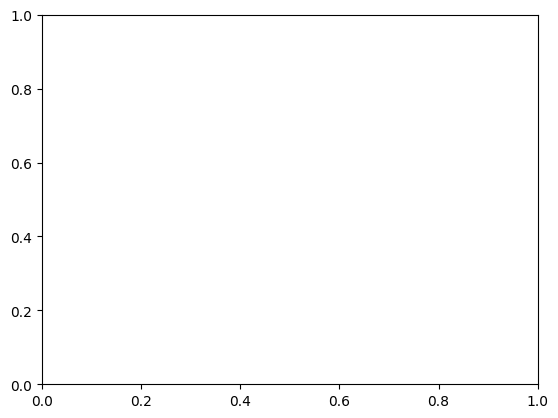

In [30]:
### NEW TRAINING CELL WITH FEATURES

extra_dim = len(SIDE_FEATS) if USE_SIDE_FEATS else 0
model = NCFModel(num_users, num_restaurants, embedding_dim=64, extra_dim=extra_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

train_losses, val_losses = [], []

PATIENCE = 3                    
best_val = float("inf")
patience_ctr = 0

for epoch in range(20):
    model.train()
    training_loss = 0.0
    total_samples = 0

    for batch in train_loader:
        # CHANGED: unpack depending on USE_SIDE_FEATS
        if USE_SIDE_FEATS:
            u, i, x, r = batch
            u, i, x, r = u.to(device), i.to(device), x.to(device), r.to(device)
            logits = model(u, i, side_feats=x).squeeze(-1)   
        else:
            u, i, r = batch
            u, i, r = u.to(device), i.to(device), r.to(device)
            logits = model(u, i).squeeze(-1)

        optimizer.zero_grad()
        loss = criterion(logits, r)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * r.size(0)
        total_samples += r.size(0)

    average_training_loss = training_loss / total_samples
    train_losses.append(average_training_loss)
    training_rmse = np.sqrt(average_training_loss)

    if average_training_loss < 1.0:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 2e-5

    model.eval()
    num_correct = 0
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            # CHANGED: same branching in eval
            if USE_SIDE_FEATS:
                u, i, x, r = batch
                u, i, x, r = u.to(device), i.to(device), x.to(device), r.to(device)
                logits = model(u, i, side_feats=x).squeeze(-1)  
            else:
                u, i, r = batch
                u, i, r = u.to(device), i.to(device), r.to(device)
                logits = model(u, i).squeeze(-1)

            all_preds.extend(logits.cpu().tolist())
            all_labels.extend(r.cpu().tolist())

            predictions = (logits >= 4).int()
            actual = (r >= 4).int()
            num_correct += (predictions == actual).sum().item()

            val_loss += criterion(logits, r).item() * r.size(0)

    average_val_loss = val_loss / len(all_preds)
    val_rmse = np.sqrt(average_val_loss)
    val_losses.append(average_val_loss)
    accuracy = num_correct / len(all_labels)

    print("====================================================================================")
    print(f"Epoch {epoch+1}:")
    print(f"Training Loss: {average_training_loss:.4f}, Validation Loss: {average_val_loss:.4f}")
    print(f"Training RMSE: {training_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    print(f"Validation Accuracy: {100*accuracy:.4f}%")
    
    if average_val_loss + 1e-6 < best_val:     
        best_val = average_val_loss
        patience_ctr = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_ctr += 1

    print(f"(early-stop) best_val={best_val:.4f} | patience={patience_ctr}/{PATIENCE}")
    if patience_ctr >= PATIENCE:
        print("Early stopping triggered.")
        break

# Plotting of training and validation loss curves
epochs_run = len(train_losses)

plt.plot(range(1, epochs_run+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs_run+1), val_losses, label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
test_df.columns

Index(['user_id', 'name', 'time', 'rating', 'text', 'gmap_id', 'u_n_reviews_x',
       'u_food_x', 'u_service_x', 'u_price_x', 'u_ambience_x',
       'u_cleanliness_x', 'u_portion_x', 'u_wait_time_x', 'u_location_x',
       'i_n_reviews_x', 'i_food_x', 'i_service_x', 'i_price_x', 'i_ambience_x',
       'i_cleanliness_x', 'i_portion_x', 'i_wait_time_x', 'i_location_x',
       'u_n_reviews_y', 'u_food_y', 'u_service_y', 'u_price_y', 'u_ambience_y',
       'u_cleanliness_y', 'u_portion_y', 'u_wait_time_y', 'u_location_y',
       'i_n_reviews_y', 'i_food_y', 'i_service_y', 'i_price_y', 'i_ambience_y',
       'i_cleanliness_y', 'i_portion_y', 'i_wait_time_y', 'i_location_y',
       'u_n_reviews', 'u_food', 'u_service', 'u_price', 'u_ambience',
       'u_cleanliness', 'u_portion', 'u_wait_time', 'u_location',
       'i_n_reviews', 'i_food', 'i_service', 'i_price', 'i_ambience',
       'i_cleanliness', 'i_portion', 'i_wait_time', 'i_location',
       'user_encoded', 'restaurant_encoded', 'lab

In [26]:
restaurant_ids_test = test_df['restaurant_encoded'].unique()
restaurant_ids_train = train_df['restaurant_encoded'].unique()

In [27]:
print(len(restaurant_ids_train))
print(len(restaurant_ids_test))


3589
3107


In [28]:
train_df['label_binary'].value_counts()
#total: 329196


label_binary
1    271255
0     57941
Name: count, dtype: int64

In [29]:
torch.save(model.state_dict(), "first_ncf_recommender.pth")